## Simpsons classification

My baseline solution for kaggle inclass competition https://www.kaggle.com/c/journey-springfield (best public score 0.99149)

In [ ]:
!pip install -U torch torchvision

In [0]:
import os
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag

platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.5.0-{platform}-linux_x86_64.whl torchvision

In [ ]:
import torch
import numpy as np

In [ ]:
!pip install Pillow
import PIL

print(PIL.__version__)

In [ ]:
!nvidia-smi
torch.cuda.is_available()

In [0]:
import pickle
import copy
import random
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path
from collections import Counter

from torchvision import transforms, models
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

## Preprocessing

In [0]:
!unzip -q /content/gdrive/My\ Drive/simpsons.zip -d data

In [0]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [0]:
DATA_MODES = ['train', 'val', 'test']
RESCALE_SIZE = 224
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [0]:
class SimpsonsDataset(Dataset):
    def __init__(self, files, mode):
        super().__init__()
        # files list
        self.files = sorted(files)
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                pickle.dump(self.label_encoder, le_dump_file)

    # simple augmentation for rare classes:
    # make image copy and apply transforms
    def make_augmentation(self, min_freq=300):
        ct = dict(Counter(self.labels))
        transform = transforms.Compose([
            transforms.RandomRotation(5),
            transforms.Resize(RESCALE_SIZE),
            transforms.RandomCrop(RESCALE_SIZE),
            transforms.RandomGrayscale(p=0.1),
            transforms.RandomHorizontalFlip(p=0.5)
        ])
        for cl, freq in ct.items():
            if freq < min_freq:
                # find indices of files with class @cl
                idxs = np.where(np.array(self.labels) == cl)
                for i in idxs[0]:
                    # make transforms for class freq to become at least @min_freq
                    for j in range(min_freq // freq + 1):
                        name = self.make_transform(self.files[i], transform, j)
                        self.files.append(name)
                        self.labels.append(cl)

    # transform PIL image given @transform
    def make_transform(self, file, transform, idx):
        x = self.load_sample(file)
        x = transform(x)
        new_name = f'{os.path.splitext(file)[0]}_{idx}.jpg'
        x.save(new_name)
        return new_name
          
    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [0]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [0]:
TRAIN_DIR = Path('/content/data/train/simpsons_dataset/')
TEST_DIR = Path('/content/data/testset/testset/')

In [0]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [0]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels, 
                                          random_state=SEED)

In [0]:
val_dataset = SimpsonsDataset(val_files, mode='val')
train_dataset = SimpsonsDataset(train_files, mode='train')
test_dataset = SimpsonsDataset(test_files, mode='test')

In [0]:
# make augmentation for rare classes
train_dataset.make_augmentation()

In [0]:
# counting weights as inverse class frequencies for weighted sampling
def count_weights(labels):
    classes, freq = np.unique(labels, return_counts=True)

    plt.hist(labels, bins=len(classes))
    plt.plot()

    weights = 1. / freq
    return weights, weights[labels]

In [0]:
# get dataloader from data
def dataloader(data, batch_size=64, shuffle=False, weights=None):
    if weights is not None:
        # balancing for rare classes, they would appear more frequently while training
        sampler = WeightedRandomSampler(weights, len(weights), replacement=True)
        loader = DataLoader(data, batch_size=batch_size, sampler=sampler)
    else:
        loader = DataLoader(data, batch_size=batch_size, shuffle=shuffle)
    return loader

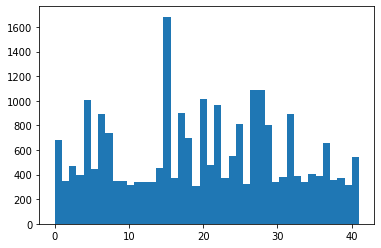

In [0]:
# weights for each class and for each sample in the training set
CLASS_W, train_w = count_weights(
    train_dataset.label_encoder.transform(train_dataset.labels))

In [0]:
BATCH_SIZE = 64

In [0]:
train_loader = dataloader(train_dataset, batch_size=BATCH_SIZE, weights=train_w)
valid_loader = dataloader(val_dataset, batch_size=BATCH_SIZE)
test_loader = dataloader(test_dataset, batch_size=BATCH_SIZE)
train_loaders = {'train': train_loader, 
                 'valid': valid_loader}

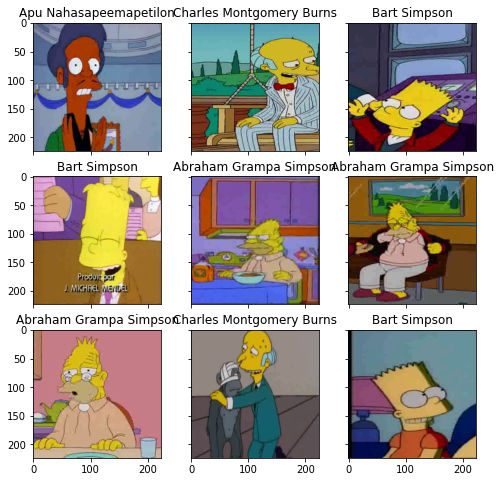

In [0]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

## Model training

In [0]:
def fit_epoch(model, criterion, optimizer, data, mode):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
    f1 = []

    if mode == 'train':
        model.train()
    else:
        model.eval()

    for inputs, labels in data:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()
        with torch.set_grad_enabled(mode == 'train'):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            if mode == 'train':
                loss.backward()
                optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            true = labels.data.cpu().numpy()
            pred = preds.cpu().numpy()
            f1.append(f1_score(true, pred, sample_weight = CLASS_W[true], 
                               average='weighted'))
            processed_data += inputs.size(0)

    loss = running_loss / processed_data
    acc = running_corrects.double().cpu().numpy() / processed_data
    return loss, acc, np.mean(f1)

In [0]:
# training log for epoch
def write_log(epoch, modes, losses, accs, f1):
    log = "\nEpoch {:03d}: ".format(epoch + 1)
    for mode in modes:
        log += "{}_loss: {:0.4f}, {}_acc {:0.4f}, {}_f1 {:0.4f};\n".format(mode, losses[mode],\
                                                     mode, accs[mode], \
                                                     mode, f1[mode])
    return log

In [0]:
def train_model(model, criterion, optimizer, scheduler, 
                dataloaders, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_f1 = 0.0; min_loss = 1e+5

    modes = dataloaders.keys()

    # learning history for each dataloader in dataloaders
    losses_hist = {mode: [] for mode in modes}
    accs_hist = {mode: [] for mode in modes}
    f1_hist = {mode: [] for mode in modes}

    epoch_losses = dict.fromkeys(modes)
    epoch_accs = dict.fromkeys(modes)
    epoch_f1 = dict.fromkeys(modes)

    with tqdm(desc="epoch", total=num_epochs) as pbar_outer:
        print()
        for epoch in range(num_epochs):
            print(f'Current lr: {scheduler.get_last_lr()}')
            for mode, data in dataloaders.items():
                loss, acc, f1 = fit_epoch(model, criterion, optimizer, data, mode)

                losses_hist[mode].append(loss); accs_hist[mode].append(acc)
                f1_hist[mode].append(f1)

                epoch_losses[mode] = loss; epoch_accs[mode] = acc; epoch_f1[mode] = f1

                if mode == 'train':
                      scheduler.step()

                # save model only if f1 and loss improved on validation set
                if mode == 'valid' and f1 > best_f1 and loss < min_loss:
                    best_f1 = f1
                    min_loss = loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    torch.save(best_model_wts, '/content/cur_best.pth')

        pbar_outer.update(1)
        tqdm.write(write_log(epoch, modes, epoch_losses, epoch_accs, epoch_f1))

    print(f'Best model F1 is {best_f1} with loss {min_loss}.')
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, losses_hist, accs_hist, f1_hist

In [0]:
def predict(model, dataloader):
    with torch.no_grad():
        logits = []
        for inputs in dataloader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
      
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [0]:
n_classes = len(np.unique(train_val_labels))
print("We will classify {} classes.".format(n_classes))

We will classify 42 classes.


In [0]:
convnet = models.resnet18(pretrained=True)

In [0]:
print(convnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
# freezing all weights
for param in convnet.parameters():
    param.requires_grad = False

# unfreezing layer4, avgpool, and classifier
for param in convnet.layer4.parameters():
    param.requires_grad = True

for param in convnet.avgpool.parameters():
    param.requires_grad = True

num_features = convnet.fc.in_features
convnet.fc = nn.Linear(num_features, n_classes)
convnet = convnet.to(DEVICE)

In [0]:
criterion = nn.CrossEntropyLoss()
params_to_upd = filter(lambda p: p.requires_grad, convnet.parameters())
optimizer = torch.optim.AdamW(params=params_to_upd, lr=1e-3)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-5, 
                                              step_size_up=10, max_lr=1e-2, 
                                              mode='triangular2', cycle_momentum=False)

In [0]:
model, losses_hist, accs_hist, f1_hist = train_model(convnet, criterion, optimizer, 
                                            scheduler, train_loaders, num_epochs=21)

epoch:   0%|          | 0/21 [00:00<?, ?it/s]


Current lr: [1e-05]


epoch:   5%|▍         | 1/21 [05:13<1:44:30, 313.53s/it]


Epoch 001: train_loss: 3.0491, train_acc 0.3432, train_f1 0.3651;
valid_loss: 2.5822, valid_acc 0.5436, valid_f1 0.6635;

Current lr: [0.001009000000000001]


epoch:  10%|▉         | 2/21 [10:25<1:39:08, 313.10s/it]


Epoch 002: train_loss: 0.2597, train_acc 0.9428, train_f1 0.9561;
valid_loss: 0.3333, valid_acc 0.9119, valid_f1 0.9492;

Current lr: [0.002008000000000002]


epoch:  14%|█▍        | 3/21 [15:34<1:33:32, 311.79s/it]


Epoch 003: train_loss: 0.1614, train_acc 0.9572, train_f1 0.9695;
valid_loss: 0.2767, valid_acc 0.9280, valid_f1 0.9581;

Current lr: [0.0030069999999999984]


epoch:  19%|█▉        | 4/21 [20:38<1:27:42, 309.54s/it]


Epoch 004: train_loss: 0.1331, train_acc 0.9631, train_f1 0.9731;
valid_loss: 0.3317, valid_acc 0.9167, valid_f1 0.9502;

Current lr: [0.004005999999999999]


epoch:  24%|██▍       | 5/21 [25:41<1:22:01, 307.57s/it]


Epoch 005: train_loss: 0.1381, train_acc 0.9618, train_f1 0.9716;
valid_loss: 0.4540, valid_acc 0.8959, valid_f1 0.9388;

Current lr: [0.005005]


epoch:  29%|██▊       | 6/21 [30:47<1:16:45, 307.06s/it]


Epoch 006: train_loss: 0.1620, train_acc 0.9571, train_f1 0.9674;
valid_loss: 0.3867, valid_acc 0.9075, valid_f1 0.9466;

Current lr: [0.006004000000000001]


epoch:  33%|███▎      | 7/21 [35:56<1:11:45, 307.57s/it]


Epoch 007: train_loss: 0.1448, train_acc 0.9627, train_f1 0.9714;
valid_loss: 0.3787, valid_acc 0.9150, valid_f1 0.9482;

Current lr: [0.007003000000000001]


epoch:  38%|███▊      | 8/21 [41:00<1:06:26, 306.67s/it]


Epoch 008: train_loss: 0.1251, train_acc 0.9662, train_f1 0.9748;
valid_loss: 0.4616, valid_acc 0.8995, valid_f1 0.9389;

Current lr: [0.008001999999999999]


epoch:  43%|████▎     | 9/21 [46:06<1:01:16, 306.37s/it]


Epoch 009: train_loss: 0.1075, train_acc 0.9715, train_f1 0.9779;
valid_loss: 0.4954, valid_acc 0.8919, valid_f1 0.9366;

Current lr: [0.009000999999999999]


epoch:  48%|████▊     | 10/21 [51:17<56:26, 307.85s/it]


Epoch 010: train_loss: 0.1490, train_acc 0.9621, train_f1 0.9701;
valid_loss: 0.4890, valid_acc 0.8901, valid_f1 0.9376;

Current lr: [0.01]


epoch:  52%|█████▏    | 11/21 [56:29<51:30, 309.09s/it]


Epoch 011: train_loss: 0.1278, train_acc 0.9670, train_f1 0.9740;
valid_loss: 0.3638, valid_acc 0.9144, valid_f1 0.9515;

Current lr: [0.009000999999999999]


epoch:  57%|█████▋    | 12/21 [1:01:40<46:25, 309.47s/it]


Epoch 012: train_loss: 0.0784, train_acc 0.9792, train_f1 0.9858;
valid_loss: 0.3109, valid_acc 0.9284, valid_f1 0.9596;

Current lr: [0.008001999999999999]


epoch:  62%|██████▏   | 13/21 [1:06:51<41:20, 310.01s/it]


Epoch 013: train_loss: 0.0375, train_acc 0.9905, train_f1 0.9944;
valid_loss: 0.2496, valid_acc 0.9440, valid_f1 0.9677;

Current lr: [0.007003000000000001]


epoch:  67%|██████▋   | 14/21 [1:12:04<36:16, 310.99s/it]


Epoch 014: train_loss: 0.0224, train_acc 0.9933, train_f1 0.9954;
valid_loss: 0.3775, valid_acc 0.9190, valid_f1 0.9531;

Current lr: [0.006004000000000001]


epoch:  71%|███████▏  | 15/21 [1:17:18<31:10, 311.82s/it]


Epoch 015: train_loss: 0.0401, train_acc 0.9900, train_f1 0.9924;
valid_loss: 0.3093, valid_acc 0.9306, valid_f1 0.9570;

Current lr: [0.005005]


epoch:  76%|███████▌  | 16/21 [1:22:31<26:01, 312.22s/it]


Epoch 016: train_loss: 0.0329, train_acc 0.9916, train_f1 0.9947;
valid_loss: 0.2766, valid_acc 0.9385, valid_f1 0.9623;

Current lr: [0.004005999999999999]


epoch:  81%|████████  | 17/21 [1:27:39<20:43, 310.83s/it]


Epoch 017: train_loss: 0.0100, train_acc 0.9974, train_f1 0.9986;
valid_loss: 0.2440, valid_acc 0.9496, valid_f1 0.9694;

Current lr: [0.0030069999999999984]


epoch:  86%|████████▌ | 18/21 [1:32:46<15:29, 309.90s/it]


Epoch 018: train_loss: 0.0091, train_acc 0.9979, train_f1 0.9987;
valid_loss: 0.2194, valid_acc 0.9566, valid_f1 0.9750;

Current lr: [0.002008000000000002]


epoch:  90%|█████████ | 19/21 [1:37:55<10:18, 309.48s/it]


Epoch 019: train_loss: 0.0040, train_acc 0.9992, train_f1 0.9997;
valid_loss: 0.2116, valid_acc 0.9572, valid_f1 0.9747;

Current lr: [0.001009000000000001]


epoch:  95%|█████████▌| 20/21 [1:43:04<05:09, 309.48s/it]


Epoch 020: train_loss: 0.0015, train_acc 0.9996, train_f1 0.9998;
valid_loss: 0.2092, valid_acc 0.9574, valid_f1 0.9746;

Current lr: [1e-05]


epoch: 100%|██████████| 21/21 [1:48:14<00:00, 309.26s/it]


Epoch 021: train_loss: 0.0020, train_acc 0.9996, train_f1 0.9998;
valid_loss: 0.2073, valid_acc 0.9591, valid_f1 0.9760;

Best model F1 is 0.9759586008121932 with loss 0.20725922854200865.


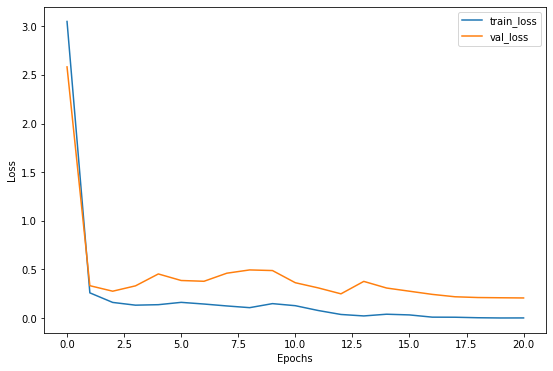

In [0]:
plt.figure(figsize=(9, 6))
plt.plot(losses_hist['train'], label='train_loss')
plt.plot(losses_hist['valid'], label='val_loss')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

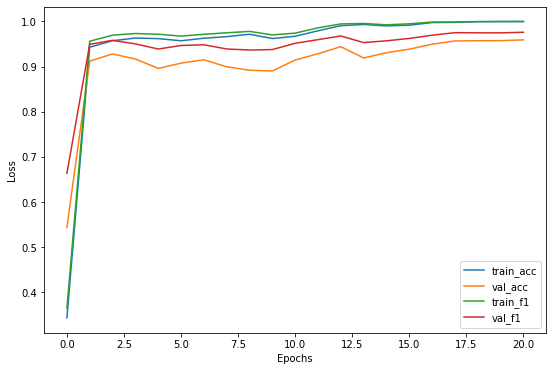

In [0]:
plt.figure(figsize=(9, 6))
plt.plot(accs_hist['train'], label='train_acc')
plt.plot(accs_hist['valid'], label='val_acc')
plt.plot(f1_hist['train'], label='train_f1')
plt.plot(f1_hist['valid'], label='val_f1')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## Prediction for random images

In [0]:
def predict_one_sample(model, inputs, device=DEVICE):
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [0]:
def predict_rand_img(model, dataset):
    random_characters = int(np.random.uniform(0, 1000))
    ex_img, true_label = dataset[random_characters]
    probs_im = predict_one_sample(model, ex_img.unsqueeze(0))
    y_pred = np.argmax(probs_im, -1)
    return probs_im, y_pred

In [0]:
def predict_rand_imgs(model, dataset, n=20):
    idxs = list(map(int, np.random.uniform(0, 1000, n)))
    imgs = [dataset[id][0].unsqueeze(0) for id in idxs]
    probs_ims = predict(model, imgs)
    y_pred = np.argmax(probs_ims,-1)
    return idxs, probs_ims, y_pred

In [0]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [0]:
idxs, probs, pred = predict_rand_imgs(convnet, val_dataset)
true = [val_dataset[id][1] for id in idxs]
preds_class = [label_encoder.classes_[i] for i in pred]

In [0]:
f1_score(true, pred, average='weighted', sample_weight = CLASS_W[true])

1.0

In [0]:
print(sum(true != pred))

0


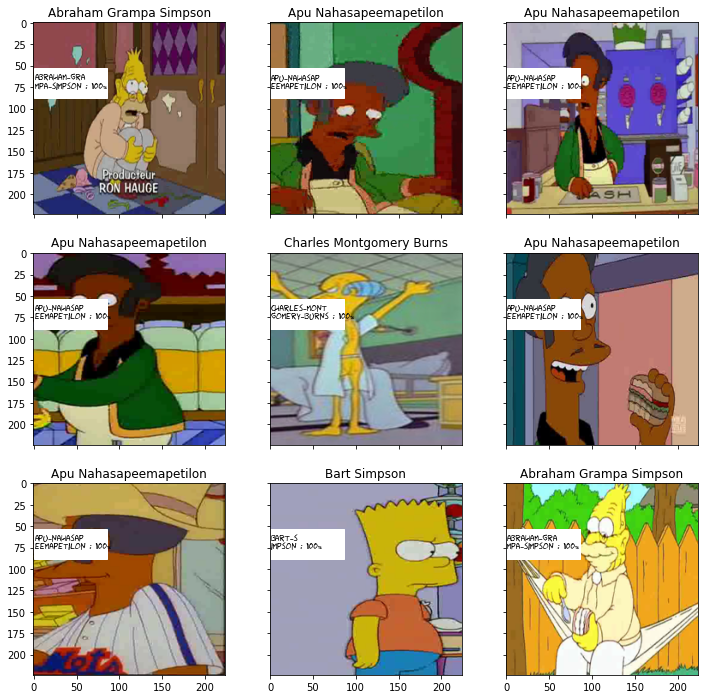

In [0]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53), 86, 35, color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(convnet, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + \
                  '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', 
               fontproperties=font,verticalalignment='top',fontsize=8, 
               color='black',fontweight='bold')

## Submit

In [0]:
probs = predict(convnet, test_loader)
preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [0]:
import pandas as pd
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [0]:
my_submit.to_csv('/content/gdrive/My Drive/resnet18.csv', index=False)